## Bayesian Zero-inflated Poisson regression modeling in R
### 2022-06-14
### Fan Zhang

In [2]:
library(rethinking)
library(tidyverse)
library(magrittr)
library(readxl)
library(cmdstanr)

# https://mc-stan.org/cmdstanr/articles/cmdstanr.html
# * Finished installing CmdStan to /Users/zhanfan/.cmdstan/cmdstan-2.29.2
# CmdStan path set to: /Users/zhanfan/.cmdstan/cmdstan-2.29.2

cmdstan_path()

[1] "/Users/zhanfan/.cmdstan/cmdstan-2.29.2"

In [6]:
# Download data set from Riehl et al. 2019

In [3]:
# Zero-inflated Poisson regression of fledged egg counts
# Thank you for the nice notebook: https://poissonisfish.com/2019/05/01/bayesian-models-in-r/
fro <- read_xlsx("/Users/zhanfan/OneDrive - The University of Colorado Denver/Zhanglab_results/2022-06-13_Bayesian_possion_rethinking/data.xlsx", sheet = 2)
sum(complete.cases(fro)) / nrow(fro)
fro[1:4,]

[1] 0.5700165

Year,Female_ID_coded,Group_ID_coded,Parasite,Min_age,Successful,Group_size,Mean_eggsize,Eggs_laid,Eggs_incu,Eggs_hatch,Eggs_fledged
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2007,299523783,NTE,0,3,0,4,28.00000,4,3,0,0
2007,299566566,NTE,0,3,0,4,27.50000,3,3,0,0
2007,299609349,STH,1,3,0,4,29.00000,7,4,0,0
2007,299652132,STH,0,3,0,4,32.33333,5,5,0,0


In [4]:
names(which(apply(fro, 2, function(x){any(is.na(x))})))

[1] "Successful"   "Group_size"   "Mean_eggsize" "Eggs_laid"    "Eggs_incu"   
[6] "Eggs_hatch"   "Eggs_fledged"

In [5]:
# Filter out missingness in fledged eggs, the model does not cope with it
fro %<>% slice(which(!is.na(Eggs_fledged))) %>% 
      as.data.frame()
dim(fro)
fro[1:4,]

[1] 575  12

,Year,Female_ID_coded,Group_ID_coded,Parasite,Min_age,Successful,Group_size,Mean_eggsize,Eggs_laid,Eggs_incu,Eggs_hatch,Eggs_fledged
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2007,299523783,NTE,0,3,0,4,28.00000,4,3,0,0
2,2007,299566566,NTE,0,3,0,4,27.50000,3,3,0,0
3,2007,299609349,STH,1,3,0,4,29.00000,7,4,0,0
4,2007,299652132,STH,0,3,0,4,32.33333,5,5,0,0


In [6]:
# add the standardised versions of Min_age, Group_size and Mean_eggsize to the dataset.
fro %<>% mutate(female_id = as.integer(factor(Female_ID_coded)),
                year_id = as.integer(factor(Year)),
                group_id = as.integer(factor(Group_ID_coded)),
                Min_age_Z = scale(Min_age),
                Group_size_Z = scale(Group_size),
                Mean_eggsize_Z = scale(Mean_eggsize))

fro[1:4,]

,Year,Female_ID_coded,Group_ID_coded,Parasite,Min_age,Successful,Group_size,Mean_eggsize,Eggs_laid,Eggs_incu,Eggs_hatch,Eggs_fledged,female_id,year_id,group_id,Min_age_Z,Group_size_Z,Mean_eggsize_Z
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,2007,299523783,NTE,0,3,0,4,28.00000,4,3,0,0,1,1,52,-0.8912904,-0.5944768,-0.7984905
2,2007,299566566,NTE,0,3,0,4,27.50000,3,3,0,0,2,1,52,-0.8912904,-0.5944768,-1.0070792
3,2007,299609349,STH,1,3,0,4,29.00000,7,4,0,0,3,1,79,-0.8912904,-0.5944768,-0.3813133
4,2007,299652132,STH,0,3,0,4,32.33333,5,5,0,0,4,1,79,-0.8912904,-0.5944768,1.0092776


In [7]:
fro <- fro[, c("Eggs_fledged", "female_id", "year_id", "group_id", "Parasite", "Min_age_Z", "Group_size_Z", "Mean_eggsize_Z")]

In [8]:
eggsFMod <- map2stan(alist(
      Eggs_fledged ~ dzipois(p, lambda),
      logit(p) <- ap,
      log(lambda) <- a + a_fem[female_id] + a_year[year_id] + a_group[group_id] +
            Parasite*bP + Min_age_Z*bA + Group_size_Z*bGS + Mean_eggsize_Z*bES +
            Parasite*Min_age_Z*bPA,
      Group_size_Z ~ dnorm(0, 3),
      Mean_eggsize_Z ~ dnorm(0, 3),
      a_fem[female_id] ~ dnorm(0, sigma1),
      a_year[year_id] ~ dnorm(0, sigma2),
      a_group[group_id] ~ dnorm(0, sigma3),
      c(sigma1, sigma2, sigma3) ~ dcauchy(0, 1),
      c(ap, a) ~ dnorm(0, 3),
      c(bP, bA, bGS, bES, bPA) ~ dnorm(0, 2)),
      data = fro,
      iter = 5e3, warmup = 1e3, chains = 4, cores = 4)

Warning message in map2stan(alist(Eggs_fledged ~ dzipois(p, lambda), logit(p) <- ap, :
“Stripping scale attributes from variable Min_age_Z”
Warning message in map2stan(alist(Eggs_fledged ~ dzipois(p, lambda), logit(p) <- ap, :
“Stripping scale attributes from variable Group_size_Z”
Warning message in map2stan(alist(Eggs_fledged ~ dzipois(p, lambda), logit(p) <- ap, :
“Stripping scale attributes from variable Mean_eggsize_Z”
Imputing 23 missing values (NA) in variable 'Group_size_Z'.

Imputing 215 missing values (NA) in variable 'Mean_eggsize_Z'.

Warning in '/var/folders/dk/5nxbmwrn761gz48jk4ydfxh00000gq/T/RtmpfNw7lB/model-5d64584bb46.stan', line 11, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/dk/5nxbmwrn761gz48jk4ydfxh00000gq/T/RtmpfNw7lB/model-5d6458

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 5000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/dk/5nxbmwrn761gz48jk4ydfxh00000gq/T/RtmpfNw7lB/model-5d64584bb46.stan', line 62, column 4 to column 33)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration:    1 / 5000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/dk/5nxbmwrn761gz48jk4ydfxh00000gq/T/RtmpfNw7lB/model-5d64584bb46.stan', line 60, column 4 to column 35)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 3 Iteration:    1 / 5000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 5000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/dk/5nxbmwrn761gz48jk4ydfxh00000gq/T/RtmpfNw7lB/model-5d64584bb46.stan', line 60, column 4 to column 35)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 1 Iteration:  100 / 5000 [  2%]  (Warmup) 
Chain 3 Iteration:  100 / 5000 [  2%]  (Warmup) 
Chain 4 Iteration:  100 / 5000 [  2%]  (Warmup) 
Chain 2 Iteration:  100 / 5000 [  2%]  (Warmup) 
Chain 2 Iteration:  200 / 5000 [  4%]  (Warmup) 
Chain 3 Iteration:  200 / 5000 [  4%]  (Warmup) 
Chain 1 Iteration:  200 / 5000 [  4%]  (Warmup) 
Chain 4 Iteration:  200 / 5000 [  4%]  (Warmup) 
Chain 2 Iteration:  300 / 5000 [  6%]  (Warmup) 
Chain 3 Iteration:  300 / 5000 [  6%]  (Warmup) 
Chain 1 Iteration:  300 / 5000 [  6%]  (Warmup) 
Chain 2 Iteration:  400 / 5000 [  8%]  (Warmup) 
Chain 3 Iteration:  400 / 5000 [  8%]  (Warmup) 
Chain 4 Iteration:  300 / 5000 [  6%]  (Warmup) 
Chain 1 Iteration:  400 / 5000 [  8%]  (Warmup) 
Chain 3 Iteration:  500 / 5000 [ 10%]  (Warmup) 
Chain 2 Iteration:  500 / 5000 [ 10%]  (Warmup) 
Chain 4 Iteration:  400 / 5000 [  8%]  (Warmup) 
Chain 3 Iteration:  600 / 5000 [ 12%]  (Warmup) 
Chain 2 Iteration:  600 / 5000 [ 12%]  (Warmup) 
Chain 1 Iteration:  

See https://mc-stan.org/misc/warnings for details.


See https://mc-stan.org/misc/warnings for details.


See https://mc-stan.org/misc/warnings for details.


Computing WAIC

Warning message in map2stan(alist(Eggs_fledged ~ dzipois(p, lambda), logit(p) <- ap, :
“There were 5 divergent iterations during sampling.
Check the chains (trace plots, n_eff, Rhat) carefully to ensure they are valid.”


In [9]:
# Check posterior dists
# a + a_fem[female_id] + a_year[year_id] + a_group[group_id] +
#             Parasite*bP + Min_age_Z*bA + Group_size_Z*bGS + Mean_eggsize_Z*bES +
#             Parasite*Min_age_Z*bPA,
precis(eggsFMod, prob = .95) # use depth = 2 for varying intercepts

2850 vector or matrix parameters hidden. Use depth=2 to show them.



,mean,sd,2.5%,97.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sigma1,0.07740936,0.05648256,0.01134979,0.21632018,45.39056,1.1121629
sigma2,0.44160636,0.18257574,0.11614348,0.84625052,4160.01619,1.0014912
sigma3,1.26888031,0.22524395,0.86277550,1.74329925,2356.65749,1.0009353
ap,-0.52389935,0.20953148,-0.95043575,-0.13159942,6502.85782,1.0003385
a,-0.51110886,0.29345201,-1.11201800,0.03694034,2854.68035,1.0006996
bP,-0.45847350,0.39231948,-1.24867350,0.29104642,14283.44519,1.0000996
bA,0.02182233,0.07994770,-0.13808355,0.17577015,11699.04584,1.0002129
bGS,0.04380368,0.07427425,-0.10219922,0.19115797,11657.52523,0.9999074
bES,0.02157585,0.04285351,-0.06243308,0.10679015,10043.40507,1.0001750


In [24]:
# Sample posterior
post <- extract.samples(eggsFMod, n = 1000)

In [25]:
dim(post$a)

[1] 1000

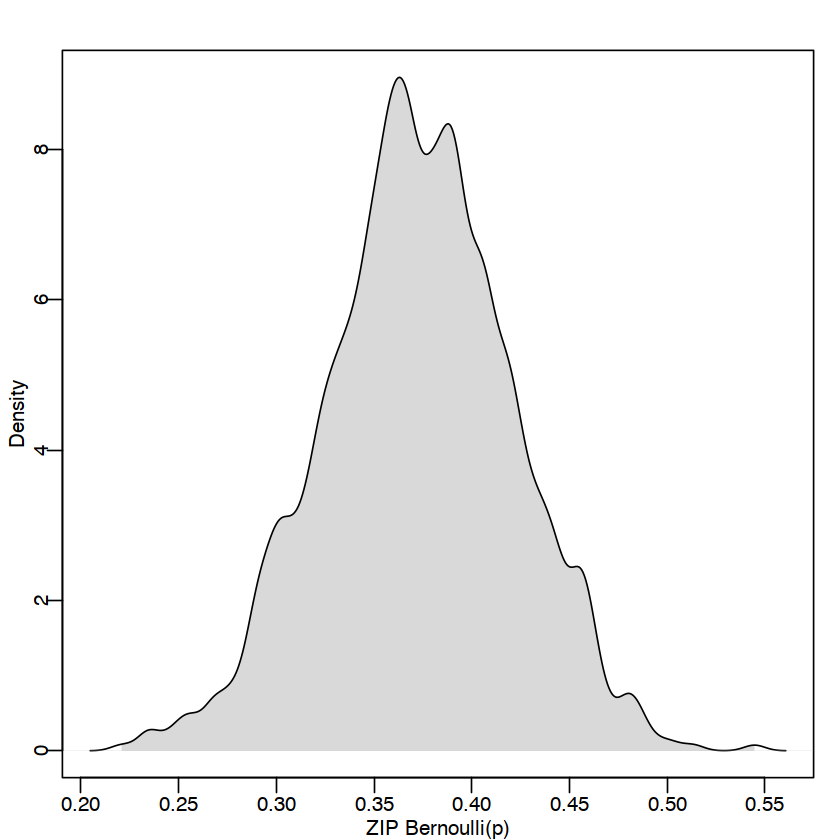

In [26]:
# PI of P(no clutch at all)
# This shows the posterior probability distribution of p , the parameter that goes into the binomial component of the model.
# It spans the interval between 0.20 and 0.50. 
# Take this as the likelihood of producing a zero instead of following a Poisson distribution in any single Bernoulli trial.

dens(logistic(post$ap), show.HPDI = T, xlab = "ZIP Bernoulli(p)")

In [22]:
# Run simulations w/ averages of all predictors, except parasite 0 / 1
lambdaNoP <- exp(post$a + 0*post$bP + 0*post$bA +
                       0*post$bGS + 0*post$bES + 0*0*post$bPA)
simFledgeNoPar <- rpois(n = length(lambdaNoP), lambda = lambdaNoP)

lambdaP <- exp(post$a + 1*post$bP + 0*post$bA +
                     0*post$bGS + 0*post$bES + 1*0*post$bPA)
simFledgePar <- rpois(n = length(lambdaP), lambda = lambdaP)
table(simFledgeNoPar)
table(simFledgePar)


simFledgeNoPar
  0   1   2   3   4   5 
870 516 172  36   5   1 

simFledgePar
   0    1    2    3    4    5 
1041  423  109   22    3    2 

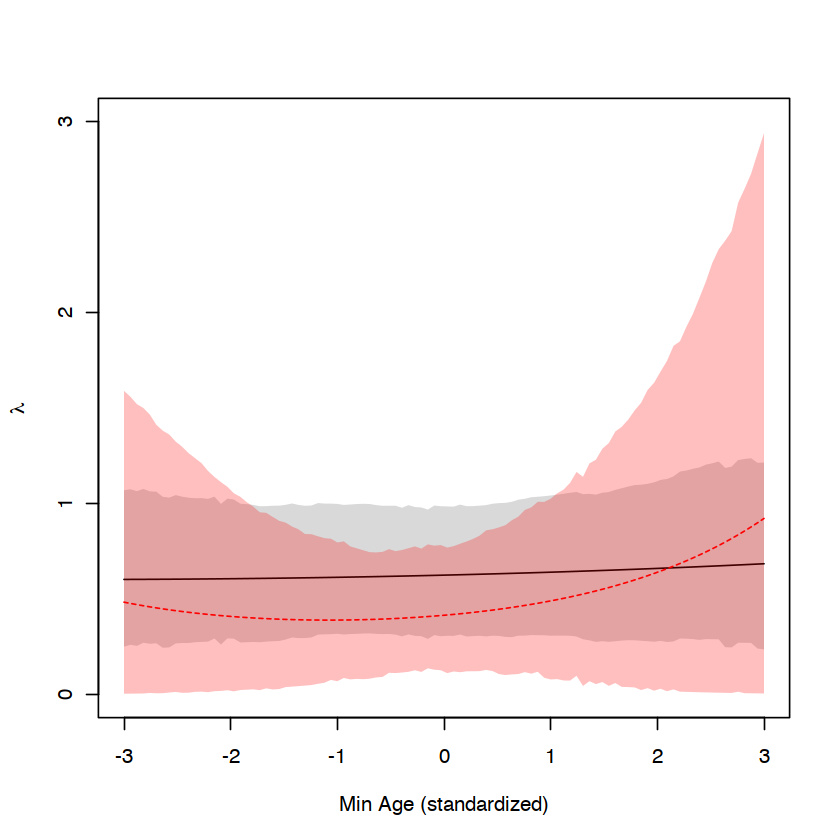

In [23]:
# Simulate with varying age
rangeA <- seq(-3, 3, length.out = 100)
# No parasite
predictions <- sapply(rangeA, function(x){
      exp(post$a + 0*post$bP + x*post$bA + 0*post$bGS +
                0*post$bES + 0*x*post$bPA)
})
hdpiPois <- apply(predictions, 2, HPDI, prob = .95)
meanPois <- colMeans(predictions)
plot(rangeA, meanPois, type = "l", ylim = c(0, 3), yaxp = c(0, 3, 3),
     xlab = "Min Age (standardized)", ylab = expression(lambda))
shade(hdpiPois, rangeA)
# Parasite
predictionsP <- sapply(rangeA, function(x){
      exp(post$a + 1*post$bP + x*post$bA + 0*post$bGS +
                0*post$bES + x*post$bPA)
})
hdpiPoisP <- apply(predictionsP, 2, HPDI, prob = .95)
meanPoisP <- colMeans(predictionsP)
lines(rangeA, meanPoisP, lty = 2, col = "red")
shade(hdpiPoisP, rangeA, col = rgb(1,0,0,.25))